# Consigna:
- Implementar la función `create_gauss_filter (h, w, k_size , sigma)` para crear filtros gaussianos para filtrado espectral.
Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada de Fourier.
    - Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una imagen para validar el funcionamiento en el dominio espectral.
    - Usando el método descripto en el paper Image Sharpness Measure for Blurred Images in Frequency Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.
    - Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of focus measure operators in shape from focus”


# Resolución
## Importación de librerías públicas

In [8]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

%matplotlib inline

## Importación de módulos codeados en el repo

In [9]:
# Set path to reach src folder
import sys

sys.path.append("../")

In [10]:
from src.filter_utils import (
    absolute_central_moment_quality_measure,
    create_gauss_filter,
    img_to_shifted_fourier,
    sharpness_method_quality_measure,
    shifted_fourier_to_img,
)

from src.img_utils import load_as_gray

### Creacion de ejemplos de filtros gaussianos y representación

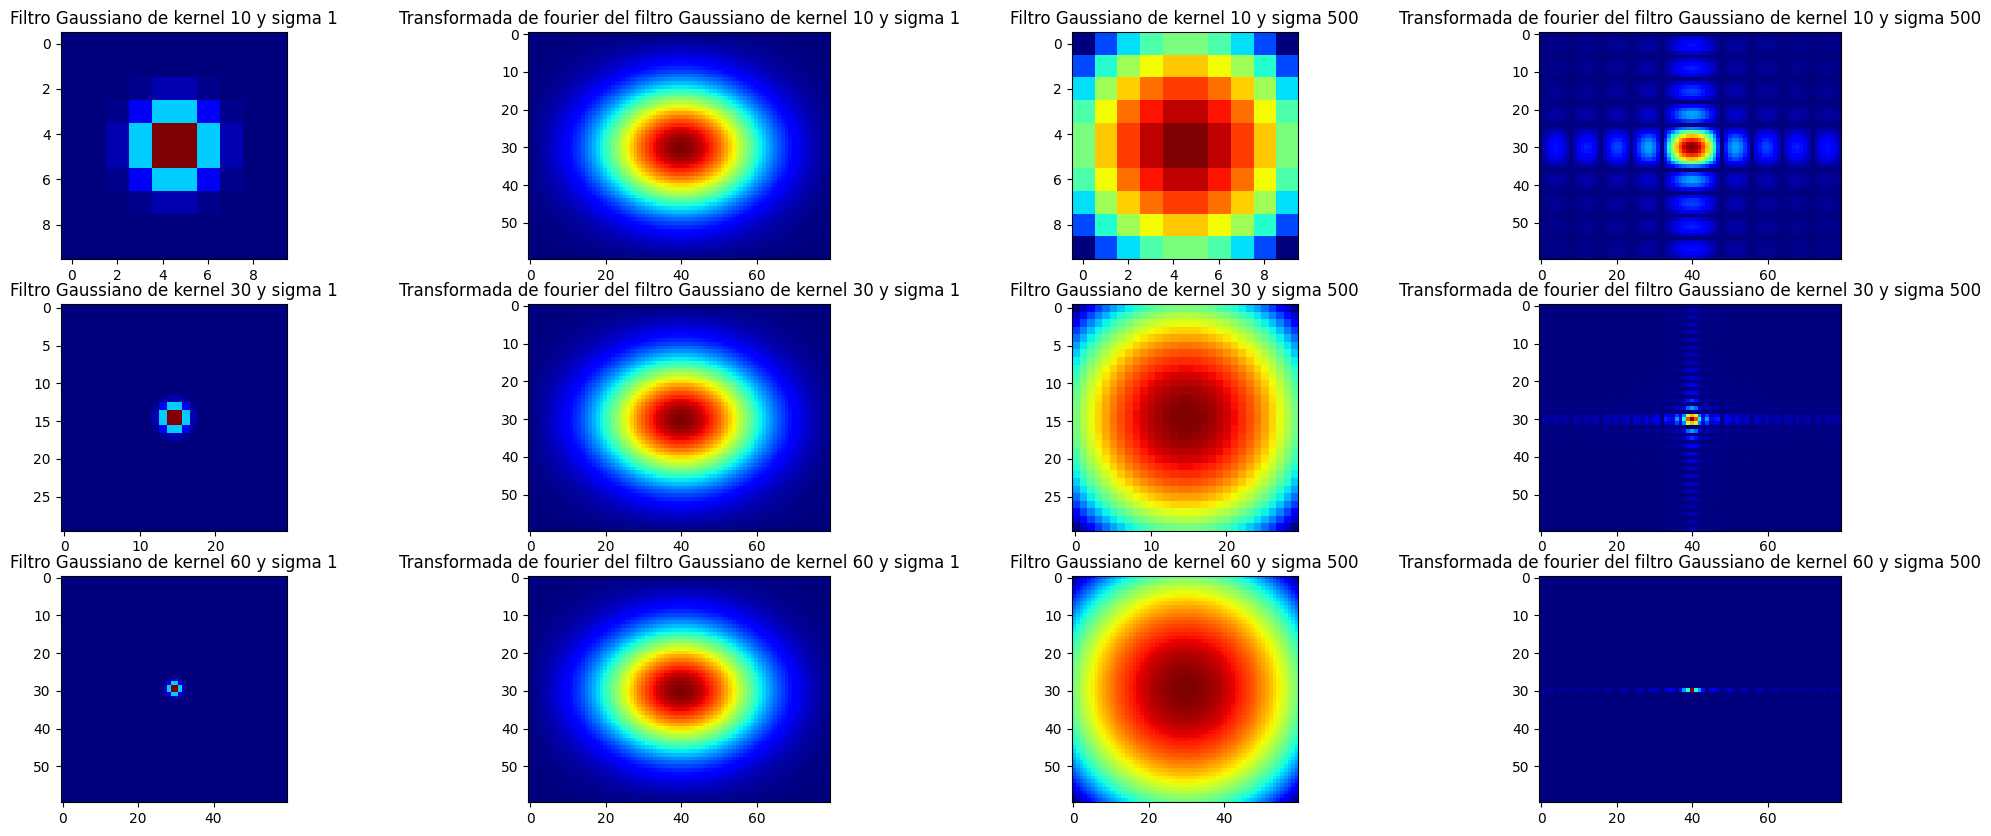

In [11]:
kernel_sizes = [10, 30, 60]
sigmas = [1, 500]
img_height = 60
img_width = 80

# Show images in three rows
fig, axes = plt.subplots(3, 4, figsize=(25, 10))

for i, k in enumerate(kernel_sizes):
    for j, s in enumerate(sigmas):
        gauss_kernel, gauss_fft = create_gauss_filter(img_height, img_width, k, s)
        axes[i][j * 2].imshow(gauss_kernel, cmap="jet")
        axes[i][j * 2].set_title(f"Filtro Gaussiano de kernel {k} y sigma {s}")

        axes[i][j * 2 + 1].imshow(np.log(1 + np.abs(gauss_fft)), cmap="jet")
        axes[i][j * 2 + 1].set_title(
            f"Transformada de fourier del filtro Gaussiano de kernel {k} y sigma {s}"
        )

### Aplicar filtro gaussiano a una imagen de ejemplo

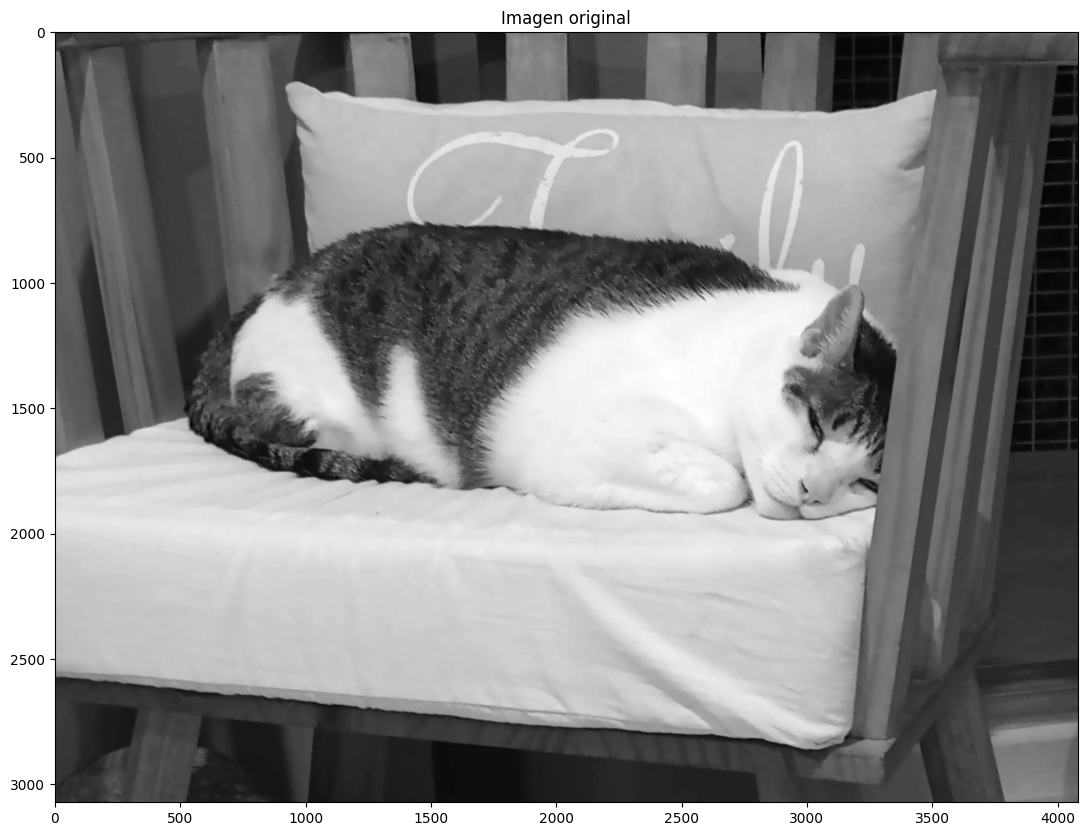

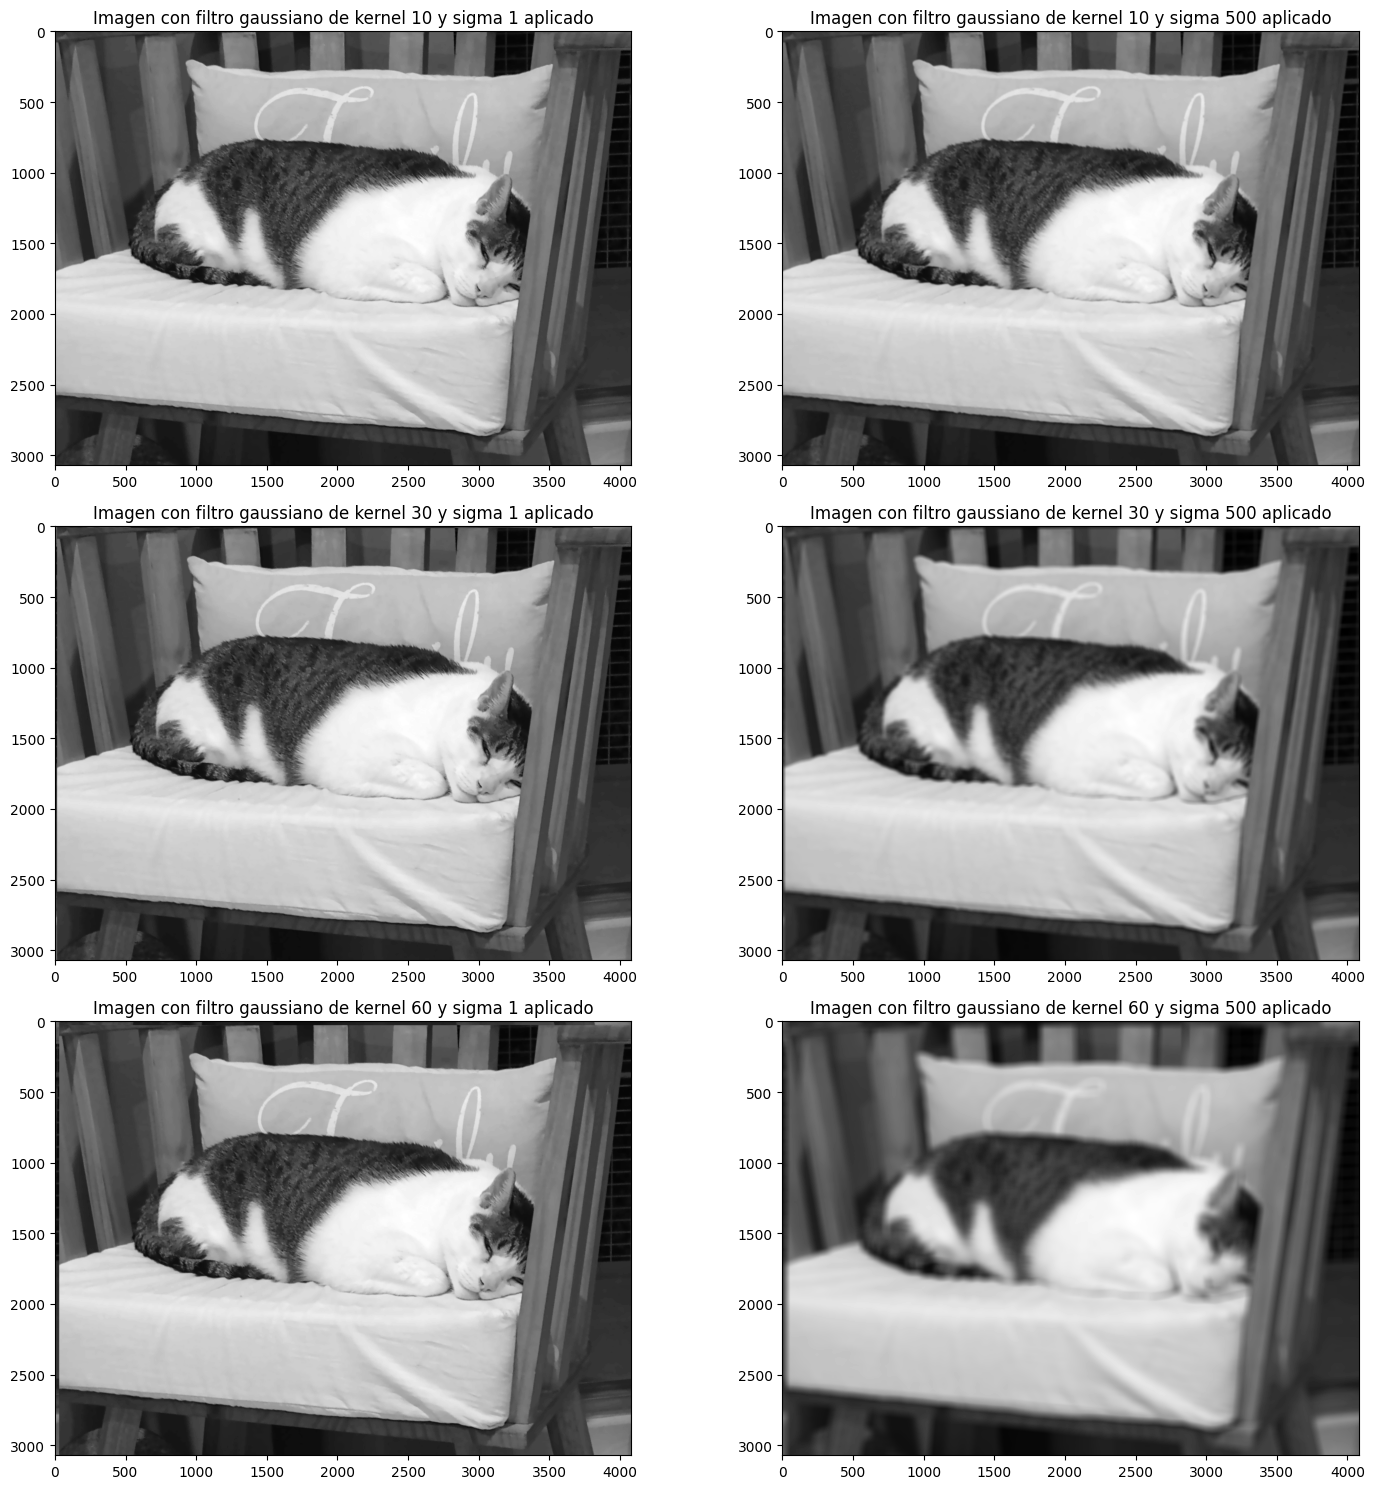

In [12]:
img = load_as_gray("resources/imagen.jpg")

height, width = img.shape

# Show original image
fig, axes = plt.subplots(1, 1, figsize=(30, 10))

axes.imshow(img, cmap="gray")
axes.set_title(f"Imagen original")

fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Apply gaussian masks to the original image. Show the result in another figure
img_fft = img_to_shifted_fourier(img, height, width)
for i, k in enumerate(kernel_sizes):
    for j, s in enumerate(sigmas):
        _, gauss_fft = create_gauss_filter(height, width, k, s)
        masked_img_fft = img_fft * gauss_fft
        masked_img = shifted_fourier_to_img(masked_img_fft)
        axes[i][j].imshow(masked_img, cmap="gray")
        axes[i][j].set_title(
            f"Imagen con filtro gaussiano de kernel {k} y sigma {s} aplicado"
        )

plt.tight_layout()
plt.show()

## Método Image Sharpness

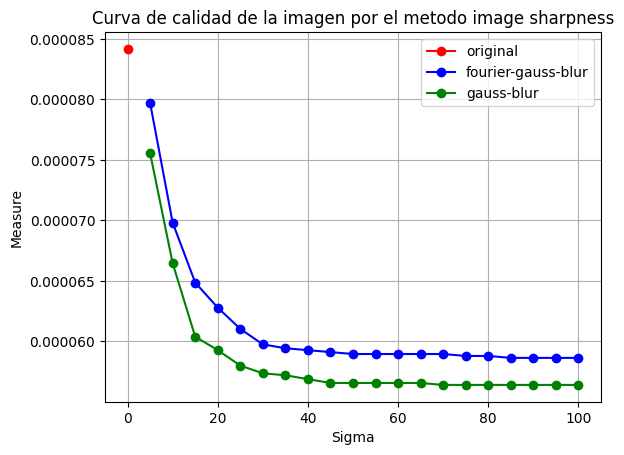

In [13]:
kernel_size = 51
test_sigmas = range(5, 105, 5)

# Build measure array following the sharpness quality method
fourier_measures = []
gauss_measures = []
for i, s in enumerate(test_sigmas):
    # fourier measure
    _, gauss_fft = create_gauss_filter(height, width, kernel_size, s)
    masked_img_fft = img_fft * gauss_fft
    masked_img = shifted_fourier_to_img(masked_img_fft)
    fourier_measures.append(sharpness_method_quality_measure(masked_img))

    # gauss measure
    gauss_measures.append(
        sharpness_method_quality_measure(
            cv.GaussianBlur(img, (kernel_size, kernel_size), sigmaX=s, sigmaY=s)
        )
    )

# Show plot
plt.plot(
    [0],
    [sharpness_method_quality_measure(img)],
    marker="o",
    color="r",
    label="original",
)
plt.plot(
    test_sigmas,
    fourier_measures,
    marker="o",
    linestyle="-",
    color="b",
    label="fourier-gauss-blur",
)
plt.plot(
    test_sigmas,
    gauss_measures,
    marker="o",
    linestyle="-",
    color="g",
    label="gauss-blur",
)
plt.title("Curva de calidad de la imagen por el metodo image sharpness")
plt.xlabel("Sigma")
plt.ylabel("Measure")

# Y tick label adjustement
plt.ticklabel_format(axis="y", style="plain")
plt.grid(True)
plt.legend()
plt.show()

#### Comentario de los resultados
Teniendo en cuenta que la puntuacion de la imagen original es de 0.000085 aproximadamente, este método de detección de blur en imágenes es sensible al filtro gaussiano. Esto tiene sentido si se compara el aspecto de las imágenes borrosas del paper con el aspecto que tiene un kernel gaussiano con un alto valor de sigma en su transformada de fourier

### Método adicional (Absolute Central Moment)

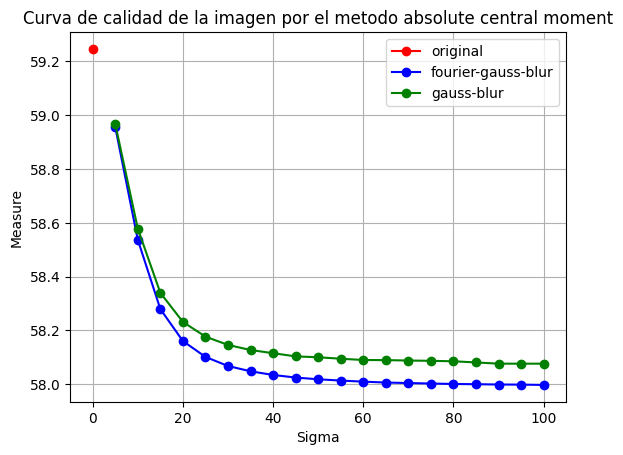

In [14]:
kernel_size = 51
test_sigmas = range(5, 105, 5)

# Build measure array following the sharpness quality method
fourier_measures = []
gauss_measures = []
for i, s in enumerate(test_sigmas):
    # fourier measure
    _, gauss_fft = create_gauss_filter(height, width, kernel_size, s)
    masked_img_fft = img_fft * gauss_fft
    masked_img = shifted_fourier_to_img(masked_img_fft)
    fourier_measures.append(absolute_central_moment_quality_measure(masked_img))

    # gauss measure
    gauss_measures.append(
        absolute_central_moment_quality_measure(
            cv.GaussianBlur(img, (kernel_size, kernel_size), sigmaX=s, sigmaY=s)
        )
    )


# Show plot
plt.plot(
    [0],
    [absolute_central_moment_quality_measure(img)],
    marker="o",
    color="r",
    label="original",
)
plt.plot(
    test_sigmas,
    fourier_measures,
    marker="o",
    linestyle="-",
    color="b",
    label="fourier-gauss-blur",
)
plt.plot(
    test_sigmas,
    gauss_measures,
    marker="o",
    linestyle="-",
    color="g",
    label="gauss-blur",
)
plt.title("Curva de calidad de la imagen por el metodo absolute central moment")
plt.xlabel("Sigma")
plt.ylabel("Measure")

# Y tick label adjustement
plt.ticklabel_format(axis="y", style="plain")
plt.grid(True)
plt.legend()
plt.show()